### Objectif : atteindre une neutralité carbone d'ici 2050
Nous nous intéressons aux **émissions** des **batiments non destinés à l'habitation**.

La problématique : Des relevés minutieux des émissions ont été faits mais sont couteux à réaliser

### L'objectif :
- prédire les émissions de CO2
- prédire la consommation totale d'énergie

   -> Pour des batiments où la mesure n'a pas encore été faite

Evaluer l'intérêt de l'energy star score pour la prédiction d'émissions carbone
* tenter de trouver une méthode alternative car ce score est fastidieux à calculer

### Objectifs à prendre en compte :
- se passer des relevés de consommation annuels, utiliser les caractéristiques intrinsèques des batiments.
- appliquer des transformations simples aux variables (norm / log) et feature engineering comme exploiter une addresse
- mettre en place une selection rigoureuse d'algorithmes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
from sklearn.impute import KNNImputer

In [2]:
data_2015 = pd.read_csv('2015-building-energy-benchmarking.csv')
data_2016 = pd.read_csv('2016-building-energy-benchmarking.csv')

In [3]:
data_2015.shape

(3340, 47)

In [4]:
data_2016.shape

(3376, 46)

## Fusion des jeux de données 
Nous allons commencer par étudier les différences entre les deux années de mesure afin de construire un seul dataframe prenant en compte 2015 et 2016.

In [5]:
def compare_df():
    colUniques2015 = data_2015.columns[~data_2015.columns.isin(data_2016)]
    colUniques2016 = data_2016.columns[~data_2016.columns.isin(data_2015)]
    n_incompatibles = len(colUniques2015) + len(colUniques2016)

    print(f'Il reste {n_incompatibles} colonnes incompatibles entre les jeux de données.')
    print("__________________ \n")
    print("Colonnes présentes en 2015 et absentes en 2016: \n")
    print(colUniques2015)
    print("__________________ \n")
    print("Colonnes présentes en 2016 et absentes en 2015: \n")
    print(colUniques2016,'\n')
    print("__________________")


In [6]:
compare_df()

Il reste 19 colonnes incompatibles entre les jeux de données.
__________________ 

Colonnes présentes en 2015 et absentes en 2016: 

Index(['Location', 'OtherFuelUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)',
       'GHGEmissionsIntensity(kgCO2e/ft2)', 'Comment', '2010 Census Tracts',
       'Seattle Police Department Micro Community Policing Plan Areas',
       'City Council Districts', 'SPD Beats', 'Zip Codes'],
      dtype='object')
__________________ 

Colonnes présentes en 2016 et absentes en 2015: 

Index(['Address', 'City', 'State', 'ZipCode', 'Latitude', 'Longitude',
       'Comments', 'TotalGHGEmissions', 'GHGEmissionsIntensity'],
      dtype='object') 

__________________


On peut observer que certaines colonnes parlent de la même chose mais avec un nom légèrement différent par exemple : 
* GHGEmissions(MetricTonsCO2e) / TotalGHGEmissions
* Comment / Comments 

Ou encore un formatage différent :

En 2015 les informations de localisation sont toutes contenues en une variable.

In [7]:
data_2015['Location'][0]

'{\'latitude\': \'47.61219025\', \'longitude\': \'-122.33799744\', \'human_address\': \'{"address": "405 OLIVE WAY", "city": "SEATTLE", "state": "WA", "zip": "98101"}\'}'

En 2016 elles sont dans des colonnes séparées.

In [8]:
print('latitude =',data_2016['Latitude'][0])
print('ville =',data_2016['City'][0])
print('Adresse =',data_2016['Address'][0])
print("Code =",data_2016['ZipCode'][0])

latitude = 47.6122
ville = Seattle
Adresse = 405 Olive way
Code = 98101.0


* Nous allons commencer par récupérer ces informations relatives à l'emplacement d'un batiment depuis ce format string

### Extraction des informations positionnelles de la colonne 'Location'

On peut observer qu'il y a de la variabilité dans le 'zipcode'

In [9]:
data_2016['ZipCode'].unique()

array([98101., 98121., 98104., 98154., 98118., 98105., 98112., 98125.,
       98109., 98070., 98108., 98199., 98115., 98107., 98144., 98103.,
       98119., 98136., 98122., 98126., 98133., 98146., 98033., 98106.,
       98111., 98134., 98117., 98116., 98191., 98164., 98195., 98185.,
       98181., 98102., 98168., 98155., 98006., 98124., 98053., 98012.,
       98013., 98028., 98178., 98114., 98127., 98165., 98011., 98198.,
       98113., 98040., 98204., 98177., 98020., 98272., 98145.,    nan])

En revanche, conformément à nos attentes, il n'y a qu'une seule ville dans un seul état ce qui rend ces colonnes inutiles.

In [10]:
data_2016['City'].unique()

array(['Seattle'], dtype=object)

In [11]:
data_2016['State'].unique()

array(['WA'], dtype=object)

* Pas besoin de récupérer la ville et l'état: ils prennent toujours la même valeur.

Nous construisons donc des patterns regex pour extraire seulement des informations capables de différencier les lieux.

In [12]:
data_2015['Location'][0]

'{\'latitude\': \'47.61219025\', \'longitude\': \'-122.33799744\', \'human_address\': \'{"address": "405 OLIVE WAY", "city": "SEATTLE", "state": "WA", "zip": "98101"}\'}'

In [13]:
latitude_reg = re.compile("\'latitude\': \'(-?\d+.\d+)")
longitude_reg = re.compile("\'longitude\': \'(-?\d+.\d+)")
address_reg = re.compile('"address": "(.*)", "c')
num_voie_reg = re.compile('\d+')
voie_reg = re.compile(' .*')
zipcode_reg = re.compile('"zip": "(\d+)')

In [14]:
# ces deux fonctions nous permetttent de partionner les informations contenues dans la string 'Location'

# première extraction des différentes informations
def extract_location(string):
    latitude  = re.findall(latitude_reg,string)[0]
    longitude = re.findall(longitude_reg,string)[0]
    address   = re.findall(address_reg,string)[0]
    num_voie, voie  = parse_address(address)
    zipcode = re.findall(zipcode_reg,string)[0]
    return latitude, longitude, num_voie, voie, zipcode

# découpage plus précis de l'addresse en la voie et son numéro
def parse_address(address):
    num_voie  = re.findall(num_voie_reg,address)[0]
    voie      = re.findall(voie_reg,address)[0].lstrip()
    return num_voie,voie

Nous découpons l'addresse en la rue et le numéro car sans cette scission, chaque adresse serait unique et aucune relation entre addresse et consommation energétique ne pourrait être repérée.
- Les activités similaires ont souvent tendance à se regrouper sur des axes routiers (magasins, concessions, bureaux)
- Il peut être intéressant de voir si certaines voies caractéristiques d'un certain type de batiment sont plus fortement liées à des tendances de consommation énergétique / émission de gaz à effet de serre.

In [15]:
extract_location(data_2015['Location'][0])

('47.61219025', '-122.33799744', '405', 'OLIVE WAY', '98101')

In [16]:
Latitude = []
Longitude = []
numVoie = []
Voie = []
ZipCode = []

for location in data_2015['Location']:
    latitude,longitude,num_voie,voie,zipcode = extract_location(location)
    Latitude.append(float(latitude))
    Longitude.append(float(longitude))
    numVoie.append(int(num_voie))
    Voie.append(voie)
    ZipCode.append(int(zipcode))

Nous créons de nouvelles colonnes dans notre jeu de données en utilisant ces listes.

In [17]:
data_2015['Latitude'] = Latitude
data_2015['Longitude'] = Longitude
data_2015['numVoie'] = numVoie
data_2015['Voie'] = Voie
data_2015['ZipCode'] = ZipCode

In [18]:
compare_df()

Il reste 18 colonnes incompatibles entre les jeux de données.
__________________ 

Colonnes présentes en 2015 et absentes en 2016: 

Index(['Location', 'OtherFuelUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)',
       'GHGEmissionsIntensity(kgCO2e/ft2)', 'Comment', '2010 Census Tracts',
       'Seattle Police Department Micro Community Policing Plan Areas',
       'City Council Districts', 'SPD Beats', 'Zip Codes', 'numVoie', 'Voie'],
      dtype='object')
__________________ 

Colonnes présentes en 2016 et absentes en 2015: 

Index(['Address', 'City', 'State', 'Comments', 'TotalGHGEmissions',
       'GHGEmissionsIntensity'],
      dtype='object') 

__________________


Nous avons réduit le nombre de colonnes incompatibles mais nous en avons ajouté de nouvelles en découpant l'addresse en un numéro et une rue.

#### Découpage de l'addresse pour 2016

In [19]:
numVoie = []
Voie = []
for address in data_2016['Address']:
    num_voie, voie = parse_address(address)
    numVoie.append(int(num_voie))
    Voie.append(voie)

In [20]:
data_2016['numVoie'] = numVoie
data_2016['Voie'] = Voie

In [21]:
data_2015.drop(['Location',
                'Zip Codes',
                'Comment'],axis=1,inplace=True)
data_2016.drop(['Address',
                'City',
                'State',
                'Comments'],axis=1,inplace=True)

In [22]:
compare_df()

Il reste 9 colonnes incompatibles entre les jeux de données.
__________________ 

Colonnes présentes en 2015 et absentes en 2016: 

Index(['OtherFuelUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)',
       'GHGEmissionsIntensity(kgCO2e/ft2)', '2010 Census Tracts',
       'Seattle Police Department Micro Community Policing Plan Areas',
       'City Council Districts', 'SPD Beats'],
      dtype='object')
__________________ 

Colonnes présentes en 2016 et absentes en 2015: 

Index(['TotalGHGEmissions', 'GHGEmissionsIntensity'], dtype='object') 

__________________


### Comparaison des colonnes semblables aux deux dataframes
Nous allons maintenant comparer les colonnes aux noms similaires pour voir si elles mesurent bien la même chose.

In [23]:
# Cette fonction nous permet de calculer et visualiser des statistiques nous permettant de juger de la similitude des données 
def compare_vars(var1,var2):
        plot_data = list([data_2015[var1],
                          data_2016[var2]])
        annee = list([2015,2016])
        fig, ax = plt.subplots(2,2,
                           figsize=(15,5),
                           gridspec_kw={'width_ratios':[6,1]}) 
        
        title = plt.suptitle('Comparaison des variables entre 2015 et 2016',
                fontsize=20)
        title.set_position([0.55,1.05])
        ax[0,0].set_title('Distribution',fontsize=15)
        ax[0,1].set_title('Statistiques descriptives',fontsize=15)
        plt.subplots_adjust(hspace=0.5)

        for i in range(0,len(plot_data)):
            sns.boxplot(ax = ax[i,0],x=plot_data[i])
            mean = np.round(plot_data[i].mean(),2)
            median = np.round(plot_data[i].median(),2)
            std = np.round(plot_data[i].std(),2)
            ax[i,1].axis('off')
            ax[i,1].text(s=f'année = {annee[i]}',x=-0.35,y=0.85)
            ax[i,1].text(s=f'moyenne = {mean}',x=-0.35,y=0.68)
            ax[i,1].text(s=f'écart-type = {std}',x=-0.35,y=0.50)
            ax[i,1].text(s=f'médiane = {median}',x=-0.35,y=0.30)

#### GHGEmissions(MetricTonsCO2e) / TotalGHGEmissions

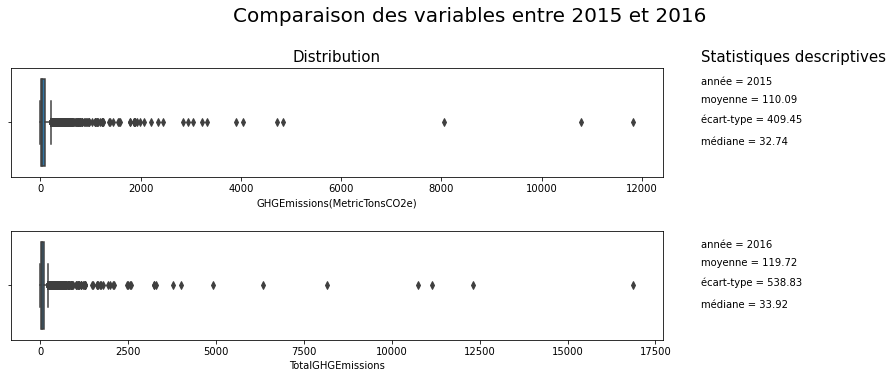

In [24]:
compare_vars('GHGEmissions(MetricTonsCO2e)','TotalGHGEmissions')

Bien que l'on observe une légère augmentation d'une année sur l'autre, il semble bien que ces deux variables soient mesurées sur la même échelle, de plus leur distributions se ressemblent.

On donne un le même nom aux variables similaires

In [25]:
data_2015.rename(columns={'GHGEmissions(MetricTonsCO2e)':'TotalGHGEmissions'},inplace=True)

### GHGEmissionsIntensity(kgCO2e/ft2) / GHGEmissionsIntensity

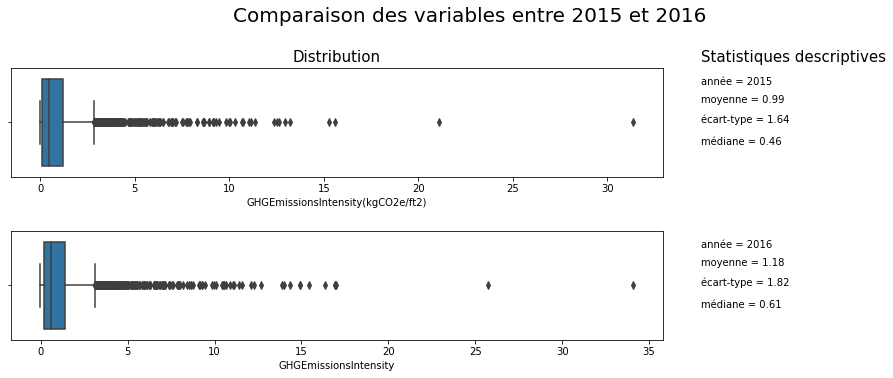

In [26]:
compare_vars('GHGEmissionsIntensity(kgCO2e/ft2)','GHGEmissionsIntensity')

Ces deux variables sont aussi similaires.

In [27]:
data_2015.rename(columns={'GHGEmissionsIntensity(kgCO2e/ft2)': 'GHGEmissionsIntensity'},inplace=True)

In [28]:
compare_df()

Il reste 5 colonnes incompatibles entre les jeux de données.
__________________ 

Colonnes présentes en 2015 et absentes en 2016: 

Index(['OtherFuelUse(kBtu)', '2010 Census Tracts',
       'Seattle Police Department Micro Community Policing Plan Areas',
       'City Council Districts', 'SPD Beats'],
      dtype='object')
__________________ 

Colonnes présentes en 2016 et absentes en 2015: 

Index([], dtype='object') 

__________________


2015 semble contenir des mesures qui n'ont pas été poursuivies en 2016.
- La ville de Seattle a jugé qu'il n'était plus utile de prendre en compte ces données, nous allons suivre leur décision.

In [29]:
data_2015.drop(data_2015.columns[~data_2015.columns.isin(data_2016)],
          axis=1,
          inplace=True)

In [30]:
compare_df()

Il reste 0 colonnes incompatibles entre les jeux de données.
__________________ 

Colonnes présentes en 2015 et absentes en 2016: 

Index([], dtype='object')
__________________ 

Colonnes présentes en 2016 et absentes en 2015: 

Index([], dtype='object') 

__________________


Avant de pouvoir fusionner les dataframes nous devons organiser leur colonnes dans le même ordre

In [31]:
data_2015 = data_2015.reindex(columns = data_2016.columns)

Nous procédons maintenant à la fusion.

In [32]:
data = pd.concat([data_2015,data_2016])

2015 et 2016 sont maintenant un seul et unique dataframe.

In [33]:
data.shape

(6716, 44)

### Suppression des batiments destinés à l'habitation
Notre objectif est de prédire la consommation de batiments non destinés à l'habitation. Nous supprimons donc tous les batiments de type habitation.

Afin de déterminer les variables les plus susceptibles de répondre à notre question nous nous basons sur les métadonnées fournies avec le dataset

In [34]:
# lecture des métadonnées Json
with open('socrata_metadata_2016-building-energy-benchmarking.json','r') as f:
       metadata2016 =  json.loads(f.read())
        
with open('socrata_metadata_2015-building-energy-benchmarking.json','r') as f:
       metadata2015 =  json.loads(f.read())

In [35]:
# Les informations qui nous intéressent sont contenues dans l'entrée 'columns' de ce dictionnaire
columns2015 = metadata2015['columns']
columns2016 = metadata2016['columns']

In [36]:
# plus précisément, c'est le nom et la description de ces colonnes que l'on veut extraire
name = []
description = []

for column in columns2015:
    name.append(column.get('name'))
    description.append(column.get('description'))
    
for column in columns2016:
    name.append(column.get('name'))
    description.append(column.get('description'))    

In [37]:
# On crée un dataframe pour les requêtes de description. 
explainedVars = pd.DataFrame({'name':name,'description':description})
explainedVars.drop_duplicates(inplace=True)

In [38]:
def get_description(name):
    description = explainedVars[explainedVars["name"]==name]['description'].values
    print(name,':\n',description,'\n_________________\n')

In [39]:
data.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'ZipCode', 'TaxParcelIdentificationNumber',
       'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude',
       'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'DefaultData', 'ComplianceStatus', 'Outlier', 'TotalGHGEmissions',
       'GHGEmissionsInt

In [40]:
get_description('PrimaryPropertyType')

PrimaryPropertyType :
 ['The primary use of a property (e.g. office, retail store). Primary use is defined as a function that accounts for more than 50% of a property. This is the Property Type - EPA Calculated field from Portfolio Manager.'] 
_________________



In [41]:
get_description('LargestPropertyUseType')

LargestPropertyUseType :
 [None 'The largest use of a property (e.g. office, retail store) by GFA. '] 
_________________



In [42]:
data['LargestPropertyUseType'].unique()

array(['Hotel', 'Police Station', 'Other - Entertainment/Public Assembly',
       'Multifamily Housing', nan, 'Library',
       'Fitness Center/Health Club/Gym', 'Social/Meeting Hall',
       'Courthouse', 'Other', 'K-12 School', 'College/University',
       'Automobile Dealership', 'Office', 'Self-Storage Facility',
       'Retail Store', 'Senior Care Community', 'Medical Office',
       'Hospital (General Medical & Surgical)', 'Museum',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'Other - Lodging/Residential', 'Residence Hall/Dormitory',
       'Other/Specialty Hospital', 'Financial Office',
       'Non-Refrigerated Warehouse', 'Distribution Center', 'Parking',
       'Worship Facility', 'Laboratory', 'Supermarket/Grocery Store',
       'Convention Center', 'Urgent Care/Clinic/Other Outpatient',
       'Other - Services', 'Strip Mall', 'Wholesale Club/Supercenter',
       'Refrigerated Warehouse', 'Other - Recreation', 'Lifestyle Center',
       'Other - Public S

In [43]:
data['PrimaryPropertyType'].unique()

array(['Hotel', 'Other', 'Mid-Rise Multifamily', 'Mixed Use Property',
       'K-12 School', 'College/University', 'Small- and Mid-Sized Office',
       'Self-Storage Facility\n', 'Distribution Center', 'Large Office',
       'Retail Store', 'Low-Rise Multifamily', 'Senior Care Community',
       'Medical Office', 'Hospital', 'Residence Hall/Dormitory',
       'Non-Refrigerated Warehouse', 'Distribution Center\n',
       'SPS-District K-12', 'Worship Facility',
       'Supermarket/Grocery Store', 'Laboratory', 'Self-Storage Facility',
       'Refrigerated Warehouse', 'High-Rise Multifamily', 'Restaurant\n',
       'Restaurant', 'University', 'Warehouse', 'Residence Hall',
       'Supermarket / Grocery Store', 'Office'], dtype=object)

In [44]:
data['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Multifamily LR (1-4)', 'Campus',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

La colonne "BuildingType" contient précisément l'information que nous recherchons.

In [45]:
habitation_reg = 'NonResiden'

In [46]:
mask = data['BuildingType'].str.contains(habitation_reg,case=False)
data = data[mask]

In [47]:
data.shape

(3075, 44)

### Obtention des données les plus récentes
Afin d'éviter trop de redondance dans les données nous ne gardons les valeurs 2015 que des batiments qui ne sont plus présents en 2016.

In [48]:
# on regarde l'identifiant unique des batiments 
redondants = data['OSEBuildingID'].value_counts()
# On récupère, séparément, l'index des batiments 
unique_index = redondants[redondants == 1].index # Les uniques 
doublons_index = redondants[redondants == 2].index # les doublons

In [49]:
# on crée un dataframe de ces lignes de batiments uniques sur une année ou l'autre
unique_lines = data[data['OSEBuildingID'].isin(unique_index)]
# et nous faisons de même sur les doublons
doublons_lines = data[data['OSEBuildingID'].isin(doublons_index)]

In [50]:
# on se débarasse de l'année 2015 dans les données qui ont été mesurées sur les deux années
lines_2016 = doublons_lines[doublons_lines['DataYear'] == 2016]

In [51]:
# enfin nous concaténons les deux dataframes 
data = pd.concat([unique_lines,lines_2016])

In [52]:
data.shape

(1575, 44)

## Analyse métier
Nous allons utiliser les métadonnées de ce dataset afin de déterminer les colonnes qui ont peu de chance d'apporter de l'information en plus

In [53]:
for name in data.columns:
    get_description(name)

OSEBuildingID :
 ['A unique identifier assigned to each property covered by the Seattle Benchmarking Ordinance for tracking and identification purposes.'] 
_________________

DataYear :
 [None 'Calendar year (January-December) represented by each data record.'] 
_________________

BuildingType :
 ['City of Seattle building type classification.'] 
_________________

PrimaryPropertyType :
 ['The primary use of a property (e.g. office, retail store). Primary use is defined as a function that accounts for more than 50% of a property. This is the Property Type - EPA Calculated field from Portfolio Manager.'] 
_________________

PropertyName :
 ['Official or common property name.'
 'Official or common property name as entered in EPA’s Portfolio Manager.'] 
_________________

ZipCode :
 ['Property zip'] 
_________________

TaxParcelIdentificationNumber :
 ['\t\nProperty King County PIN' 'Property King County PIN '] 
_________________

CouncilDistrictCode :
 ['Property City of Seattle council 

### Suppression des colonnes superflues
Nous cherchons à prédire la consomation énergétique et les émissions de CO2 
* L'objectif étant de fournir une méthode plus simple que les relevés énergétiques, nous ne prenons pas en compte ces derniers.
* Nous supprimons également les colonnes contenant des identifiants uniques, et des métadonnées de récolte

In [54]:
data = data.drop(['SourceEUI(kBtu/sf)',
                  'SteamUse(kBtu)',
                  'Electricity(kWh)',
                  'Electricity(kBtu)', 
                  'NaturalGas(therms)', 
                  'NaturalGas(kBtu)',
                  'SourceEUIWN(kBtu/sf)', 
                  'GHGEmissionsIntensity', 
                  'SiteEUI(kBtu/sf)',
                  'SiteEUIWN(kBtu/sf)', 
                  'SiteEnergyUseWN(kBtu)',
                  'ComplianceStatus',
                  'DefaultData',
                  'OSEBuildingID',
                  'DataYear',
                  'TaxParcelIdentificationNumber',
                  'PropertyName',
                  'ListOfAllPropertyUseTypes'],axis=1)

### Valeurs manquantes
Nous supprimons les colonnes et lignes contenant trop de valeurs manquantes.

In [55]:
# cette fonction donne un pourcentage de valeur manquantes sur l'ensemble du dataframe
def taux_na(dataframe,value=False):
    values = dataframe.isna().values.ravel()
    taux = round((values.sum() / len(values))*100,2)
    if value == False : # par défaut sous la forme d'une phrase
        return(f'Il y a environ {taux} % de valeurs manquantes dans le dataframe.')
    elif value == True: # mais peut renvoyer seulement le pourcentage
        return taux

# cette fonction renvoie un classement des colonnes les plus vides 
def taux_na_colonnes(dataframe):
    colsum = dataframe.isna().sum()
    colonnes = colsum.index
    valeurs = colsum.values
    pourcentage = np.round(((valeurs / dataframe.shape[0])*100),2)
    data_item = {'colonnes':colonnes,'taux NAN':valeurs,'pourcentage de NAN':pourcentage}
    return pd.DataFrame(data_item).sort_values(by='pourcentage de NAN',ascending=False)
# Cette fonction permet de visualiser un tableau dans son ensemble avec les zones contenant des données         
def plot_na(dataframe,size=(20,10)):
    plt.figure(figsize=size)
    sns.heatmap(dataframe.isna(),cbar=False);

In [56]:
taux_na(data)

'Il y a environ 18.4 % de valeurs manquantes dans le dataframe.'

#### Valeurs aberrantes.

In [57]:
data['SiteEnergyUse(kBtu)'][data['SiteEnergyUse(kBtu)'] == 0].index

Int64Index([304, 746], dtype='int64')

Deux batiments affichent n'avoir consommé aucune énergie.

In [58]:
data = data.drop(data['SiteEnergyUse(kBtu)'][data['SiteEnergyUse(kBtu)'] == 0].index,axis=0)

#### Suppression des colonnes trop vides.

In [59]:
dataNaN = taux_na_colonnes(data)
dataNaN.head(10)

,colonnes,taux NAN,pourcentage de NAN
22,Outlier,1555,98.86
19,YearsENERGYSTARCertified,1481,94.15
18,ThirdLargestPropertyUseTypeGFA,1225,77.88
17,ThirdLargestPropertyUseType,1225,77.88
16,SecondLargestPropertyUseTypeGFA,721,45.84
15,SecondLargestPropertyUseType,721,45.84
20,ENERGYSTARScore,549,34.90
2,ZipCode,16,1.02
13,LargestPropertyUseType,12,0.76
14,LargestPropertyUseTypeGFA,12,0.76


In [60]:
# L'energy star score est central à notre problématique,nous définissons notre seuil de NaN de manière à l'inclure.
dataNaN = dataNaN[dataNaN['pourcentage de NAN'] < 35] 
notSparseColumns = dataNaN['colonnes'].values
data = data.loc[:,notSparseColumns]

#### Suppression des lignes trop vides.
* nous autorisons seulement l'energystarscore à avoir des valeurs manquantes car il sera traité à part des autres données dans ce projet.

In [61]:
# On crée une liste qui contient tous les noms de colonnes à part l'energystarscore 
drop_na_list = list(data.columns)
drop_na_list.remove('ENERGYSTARScore')

In [62]:
# On utilise cette liste pour faire un subset sur la fonction dropna
# et se baser sur toutes les autres colonnes dans le traitement des valeurs manquantes
data = data.dropna(subset=drop_na_list)

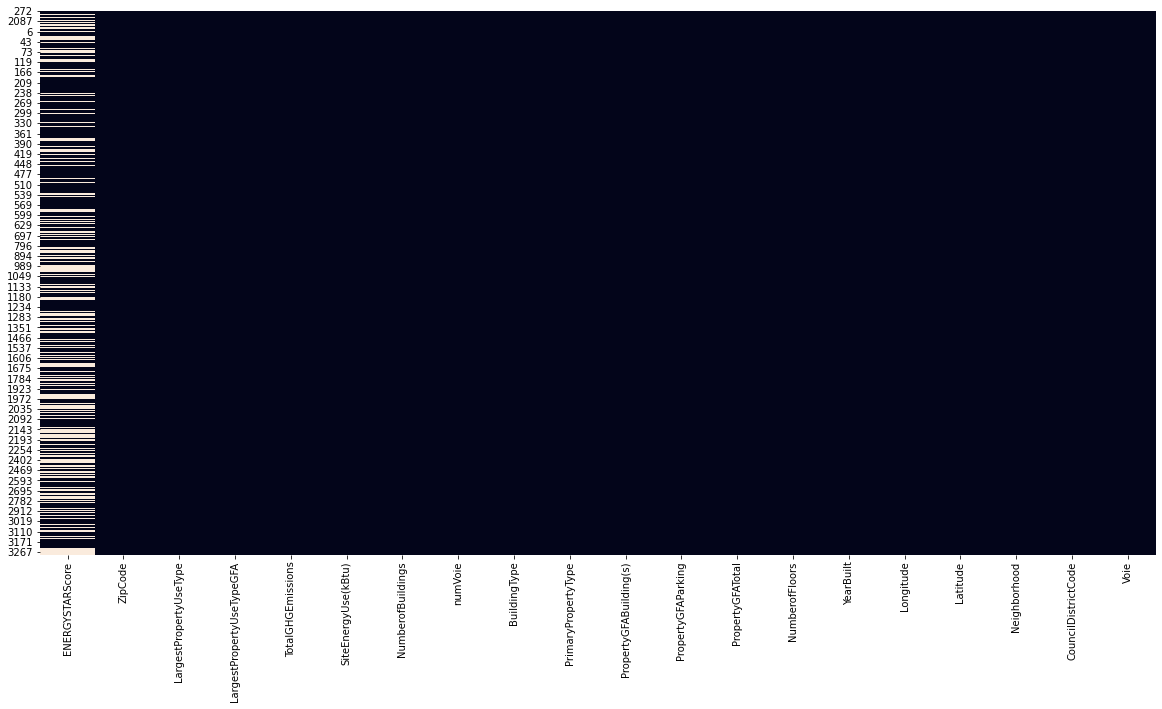

In [63]:
plot_na(data)

In [64]:
taux_na_colonnes(data).head()

,colonnes,taux NAN,pourcentage de NAN
0,ENERGYSTARScore,529,34.24
1,ZipCode,0,0.00
18,CouncilDistrictCode,0,0.00
17,Neighborhood,0,0.00
16,Latitude,0,0.00


Mis à part l'energy star score, nous avons maintenant un jeu de données sans valeurs manquantes.

### Suppression des valeurs dupliquées

In [65]:
def remove_duplicate(data):
    before = data.shape[0]
    data.drop_duplicates(inplace=True)
    after = data.shape[0]
    removed = before - after
    print(f'{removed} lignes ont été supprimées.')

In [66]:
remove_duplicate(data)

0 lignes ont été supprimées.


In [67]:
data.shape

(1545, 20)

In [68]:
data.sample(5)

,ENERGYSTARScore,ZipCode,LargestPropertyUseType,LargestPropertyUseTypeGFA,TotalGHGEmissions,SiteEnergyUse(kBtu),NumberofBuildings,numVoie,BuildingType,PrimaryPropertyType,PropertyGFABuilding(s),PropertyGFAParking,PropertyGFATotal,NumberofFloors,YearBuilt,Longitude,Latitude,Neighborhood,CouncilDistrictCode,Voie
3065,1.0,98108.0,Distribution Center,28320.0,67.96,4236396.50,1.0,601,NonResidential,Distribution Center,28320,0,28320,1.0,1971,-122.32603,47.56160,GREATER DUWAMISH,2,S. Snoqualmie Street
1021,NaN,98144.0,Distribution Center,20736.0,13.02,433871.00,1.0,1911,NonResidential,Distribution Center,23236,0,23236,1.0,1954,-122.30445,47.58607,GREATER DUWAMISH,2,22nd Avenue S
43,67.0,98101.0,Hotel,348630.0,295.33,16163194.00,1.0,1301,NonResidential,Hotel,126240,205970,332210,24.0,1969,-122.33337,47.60946,DOWNTOWN,7,Sixth Ave
2150,NaN,98106.0,Other,28303.0,92.70,3494929.50,1.0,2300,Nonresidential COS,Other,28531,0,28531,2.0,2002,-122.36205,47.53578,DELRIDGE,1,SW Webster St
2248,NaN,98134.0,Other,10471.0,44.68,1331469.75,1.0,25,NonResidential,Mixed Use Property,35310,0,35310,1.0,1952,-122.33862,47.57506,GREATER DUWAMISH,2,S Hanford St


Le travail de préparation est terminé nous écrivons les données sur disque et passons au notebook suivant pour l'analyse.

In [69]:
data.to_csv('data_seattle_clean.csv',
            sep='\t',
            index=False)